## Example. Probability of a girl birth given placenta previa

**Analysis using a uniform prior distribution**

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from scipy.special import expit

In [2]:
az.style.use('arviz-darkgrid')

%config Inline.figure_formats = ['retina']
%load_ext watermark

In [3]:
births = 987
fem_births = 437

In [4]:
with pm.Model() as model_1:
    theta = pm.Uniform('theta', lower=0, upper=1)
    obs = pm.Binomial('observed', n=births, p=theta, observed=fem_births)

In [5]:
with model_1:
    trace_1 = pm.sample(draws=20_000, tune=50_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 50_000 tune and 20_000 draw iterations (200_000 + 80_000 draws total) took 42 seconds.
The acceptance probability does not match the target. It is 0.5624345304889475, but should be close to 0.8. Try to increase the number of tuning steps.


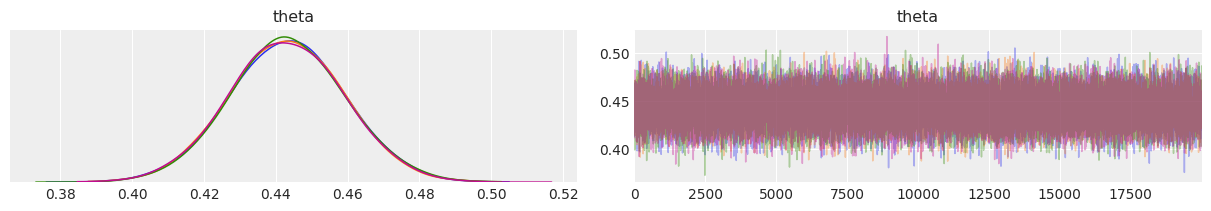

In [6]:
az.plot_trace(trace_1);

In [7]:
df = az.summary(trace_1, round_to=4)
df

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.4429,0.0158,0.4132,0.4726,0.0001,0.0001,39085.864,39041.7143,39060.2049,48001.5437,1.0


The summary shows the mean and the standard deviation, it also shows the 95% posterior interval [0.4112, 0.4732]. The next plot is the plot for the posterior distribution.

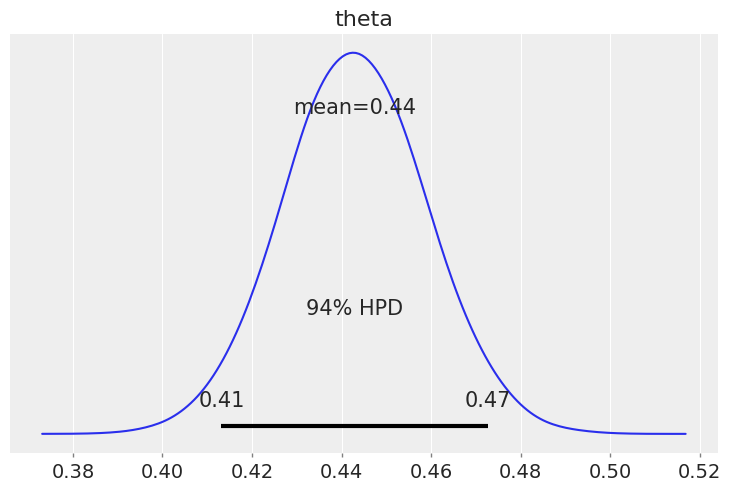

In [8]:
az.plot_posterior(trace_1); # same as pm.plot_posterior()

The true posterior distribution is $\textsf{Beta}(438, 544)$. Let's compare it with the one we found using `pymc3`.

In [9]:
from scipy.stats import beta

In [10]:
x = np.linspace(0, 1, 1000)
y = beta.pdf(x, 438, 544)

mean_t = df['mean'].values[0]
sd_t = df['sd'].values[0]
alpha_t = (mean_t**2 * (1 - mean_t)) / (sd_t**2) - mean_t
beta_t = (1 - mean_t) * (mean_t * (1 - mean_t) / sd_t**2 - 1)
y_pred = beta.pdf(x, alpha_t, beta_t)

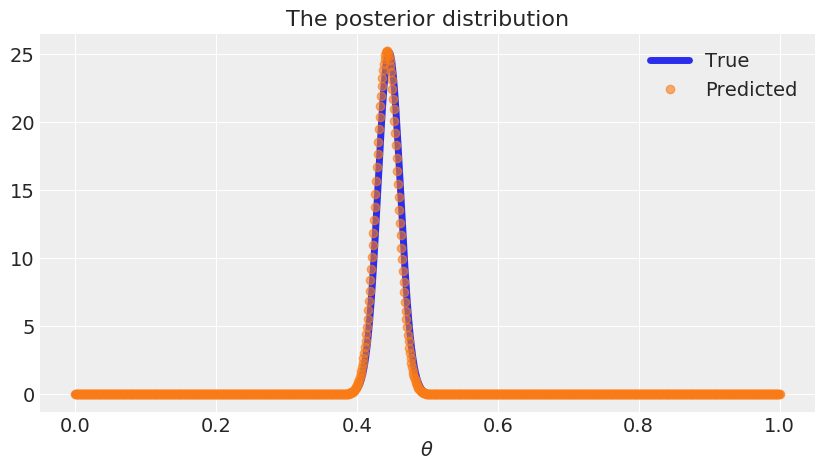

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='True', linewidth=5)
plt.plot(x, y_pred, 'o', label='Predicted', linewidth=4, alpha=0.6)
plt.legend()
plt.title('The posterior distribution')
plt.xlabel(r'$\theta$', fontsize=14);

Just like in the book, `phi` is the ratio of male to female births and `trans` is the logit transform of `theta`.

In [12]:
with pm.Model() as model_2:
    theta = pm.Uniform('theta', lower=0, upper=1)
    trans = pm.Deterministic('trans', pm.logit(theta))
    phi = pm.Deterministic('phi', (1 - theta) / theta)
    obs = pm.Binomial('observed', n=births, p=theta, observed=fem_births)

Try looking at the model's test point to see if your model has problems.

In [13]:
model_2.check_test_point()

theta_interval__    -1.39
observed           -10.15
Name: Log-probability of test_point, dtype: float64

 For comparison's sake, we change the value for `observed` to a negative number to see what happens:

In [14]:
with pm.Model() as model_2_bad:
    theta = pm.Uniform('theta', lower=0, upper=1)
    trans = pm.Deterministic('trans', pm.logit(theta))
    phi = pm.Deterministic('phi', (1 - theta) / theta)
    obs = pm.Binomial('observed', n=births, p=theta, observed=-2)

In [15]:
model_2_bad.check_test_point()

theta_interval__   -1.39
observed            -inf
Name: Log-probability of test_point, dtype: float64

In [16]:
with model_2:
    trace_2 = pm.sample(draws=5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 5 seconds.


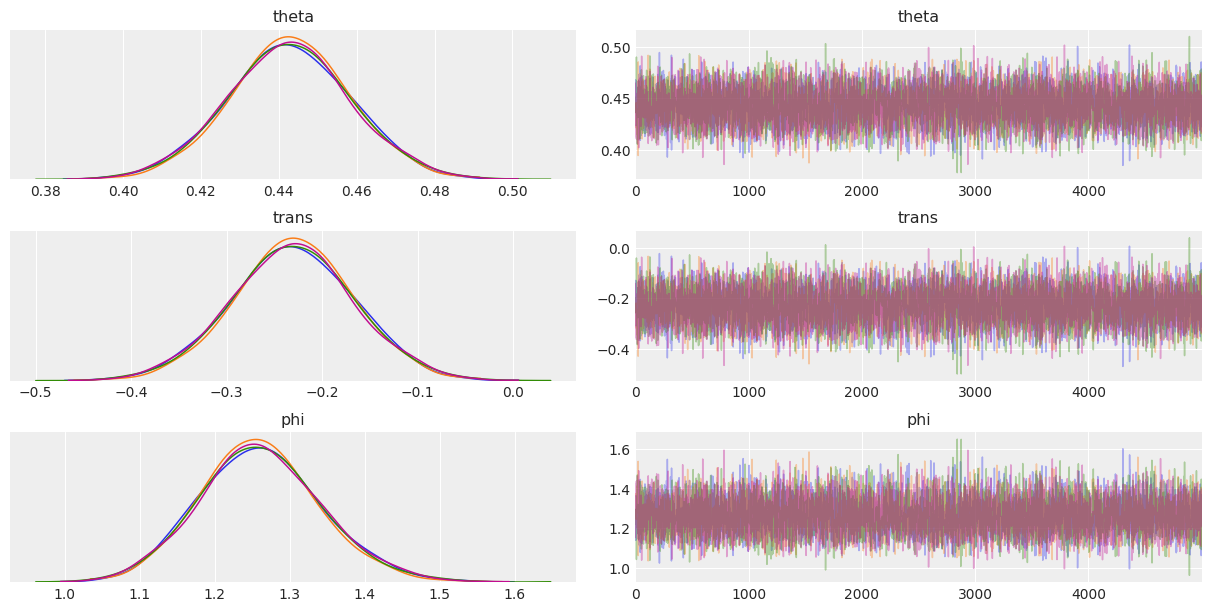

In [17]:
az.plot_trace(trace_2);

In [18]:
df2 = az.summary(trace_2, round_to=4)
df2

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.4428,0.0156,0.4141,0.4734,0.0002,0.0001,8452.2114,8447.1175,8395.9462,13384.1904,1.0004
trans,-0.2302,0.0634,-0.3470,-0.1066,0.0007,0.0005,8456.7167,8456.7167,8395.9462,13384.1904,1.0004
phi,1.2614,0.0801,1.1068,1.4087,0.0009,0.0006,8481.6104,8481.6104,8395.9462,13375.6015,1.0004


You can plot the posterior distribution for the logit transform, `trans`; the male-to-female sex ratio, `phi`.

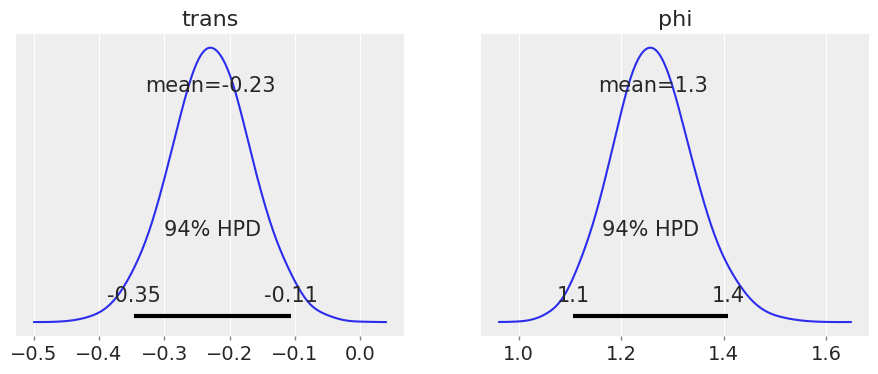

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(11, 4))
az.plot_posterior(trace_2, var_names=['trans', 'phi'], ax=axes);

If you want the interval for `trans`, you have to invert the 95% interval on the logit scale

In [20]:
lldd = expit(df2.loc['trans','hpd_3%'])
llii = expit(df2.loc['trans','hpd_97%'])

print(f'The interval is [{lldd:.3f}, {llii:.3f}]')

The interval is [0.414, 0.473]


**Analysis using a nonconjugate prior distribution**

And with a custom prior distribution, a triangular one with a uniform distribution to the left and a uniform distribution to the right. 

In [21]:
import theano.tensor as tt


def triangular(central_num, width):
    
    left_num = central_num - width
    right_num = central_num + width
    theta = pm.Triangular('theta', lower=left_num, upper=right_num, c=central_num)
    
#     Comment these lines to see some changes
    if tt.lt(left_num, theta):
        theta = pm.Uniform('theta1', lower=0, upper=left_num)
    if tt.gt(right_num, theta):
        theta = pm.Uniform('theta2', lower=right_num, upper=1)
        
    return theta 

Remember, you can play with `width`. In this case, `width=0.09`

In [22]:
central_num = 0.485
width = 0.09

with pm.Model() as model_3:
    theta = triangular(central_num, width)
    obs = pm.Binomial('observed', n=births, p=theta, observed=fem_births)

In [23]:
with model_3:
    trace_3 = pm.sample(draws=15_000, tune=15_000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta2, theta1, theta]


Sampling 4 chains for 15_000 tune and 15_000 draw iterations (60_000 + 60_000 draws total) took 35 seconds.


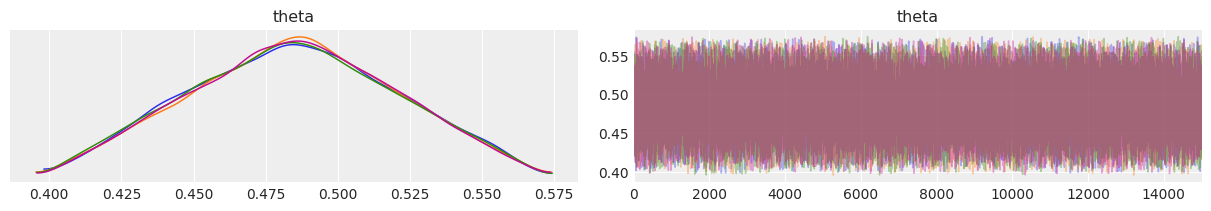

In [24]:
az.plot_trace(trace_3, var_names=['theta']);

In [25]:
az.summary(trace_3, var_names='theta', round_to=4)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.4848,0.0368,0.4183,0.5544,0.0002,0.0001,47346.7291,47333.8703,45566.4271,31447.0409,1.0001


And the posterior distribution for `theta` is this.

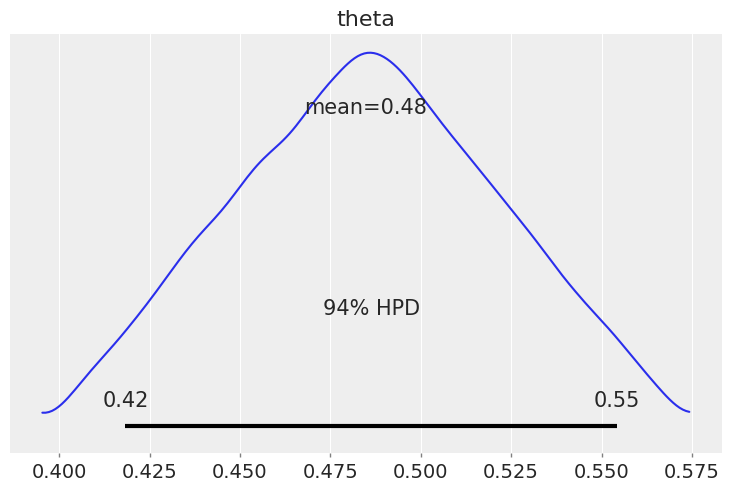

In [26]:
az.plot_posterior(trace_3, var_names='theta');

## Estimating a rate from Poisson data: an idealized example

In [27]:
with pm.Model() as poisson_model:
    theta = pm.Gamma('theta', alpha=3, beta=5)
    post = pm.Poisson('post', mu=2 * theta, observed=3)

In [28]:
poisson_model.check_test_point()

theta_log__   -0.40
post          -2.44
Name: Log-probability of test_point, dtype: float64

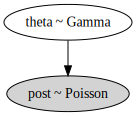

In [29]:
pm.model_to_graphviz(poisson_model)

In [30]:
with poisson_model:
    trace_poisson = pm.sample(draws=20_000, tune=10_000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 10_000 tune and 20_000 draw iterations (40_000 + 80_000 draws total) took 18 seconds.


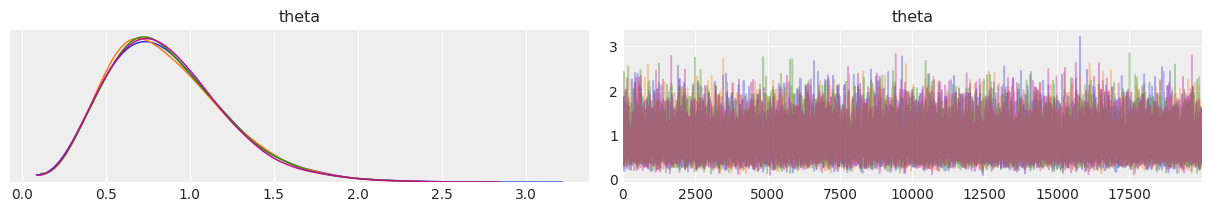

In [31]:
az.plot_trace(trace_poisson);

In [32]:
df4 = az.summary(trace_poisson, round_to=4)
df4

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.8596,0.3499,0.2637,1.5037,0.0021,0.0015,27414.1334,27414.1334,25537.9625,28346.9901,1.0001


The plot of the posterior distribution

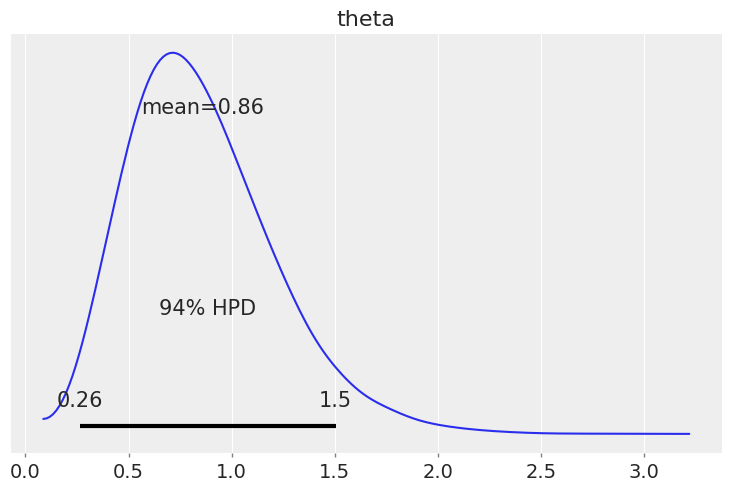

In [33]:
pm.plot_posterior(trace_poisson);

The true posterior distribution is $\textsf{Gamma}(6,7)$. Let's compare it with the one we found using `pymc3`.

In [34]:
from scipy.stats import gamma

In [35]:
x = np.linspace(0, 3, 1000)
y = gamma.pdf(x, 6, scale=1/7)

mean_t = df4['mean'].values[0]
sd_t = df4['sd'].values[0]
alpha_t = mean_t**2 / sd_t**2
beta_t = mean_t / sd_t**2
y_pred = gamma.pdf(x, alpha_t, scale=1/beta_t)

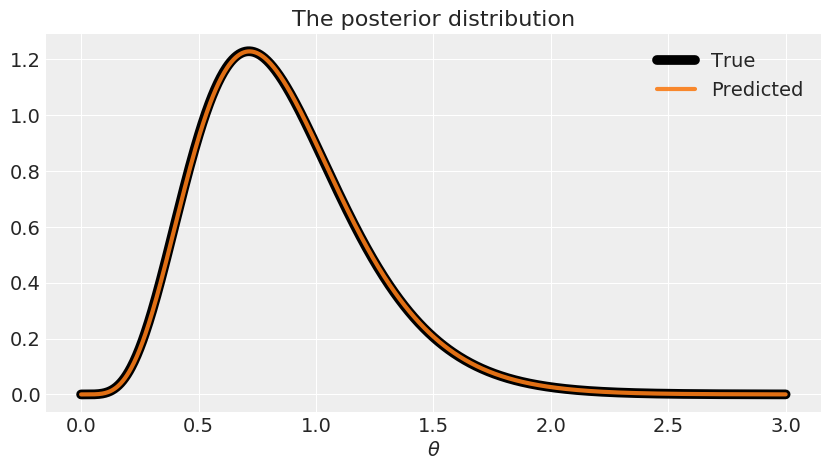

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'k', label='True', linewidth=7)
plt.plot(x, y_pred, 'C1', label='Predicted', linewidth=3, alpha=0.9)
plt.legend()
plt.title('The posterior distribution')
plt.xlabel(r'$\theta$', fontsize=14);

If we add additional data, `mu` changes.

In [37]:
with pm.Model() as poisson_model_2:
    theta = pm.Gamma('theta', alpha=3, beta=5)
    post = pm.Poisson('post', mu=20 * theta, observed=30)

In [38]:
with poisson_model_2:
    trace_poisson_2 = pm.sample(draws=10_000, tune=15_000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 15_000 tune and 10_000 draw iterations (60_000 + 40_000 draws total) took 16 seconds.


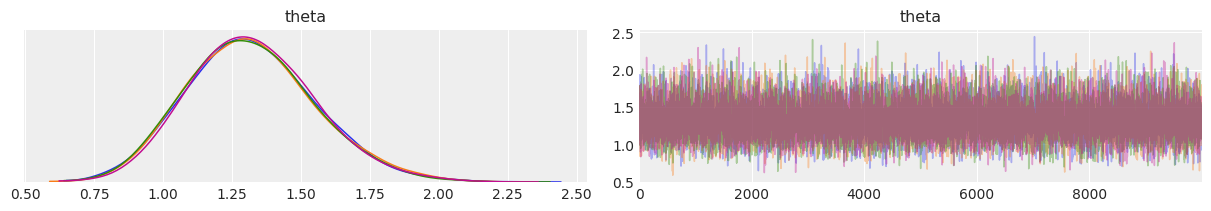

In [39]:
az.plot_trace(trace_poisson_2);

In [40]:
df5 = pm.summary(trace_poisson_2, round_to=4)
df5

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,1.3214,0.23,0.89,1.746,0.0019,0.0014,14517.8493,14494.9857,14492.4029,15560.543,1.0001


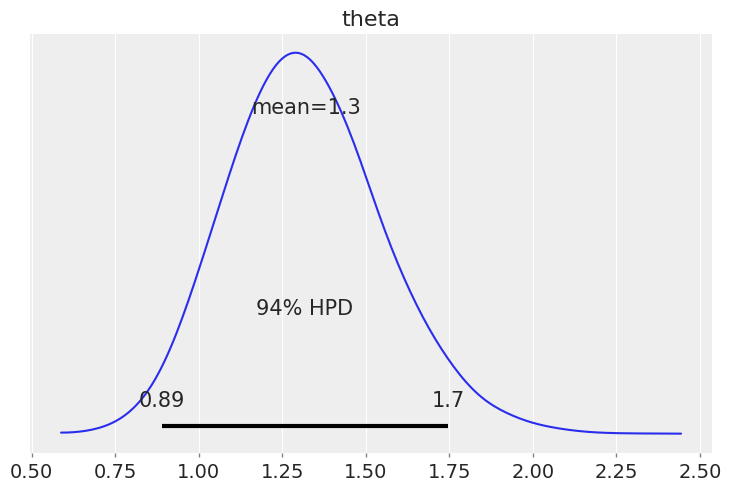

In [41]:
az.plot_posterior(trace_poisson_2);

The true posterior distribution is $\textsf{Gamma}(33, 25)$

In [42]:
x = np.linspace(0, 3, 1000)
y = gamma.pdf(x, 33, scale=1/25) # How you write alpha and beta

mean_t = df5['mean'].values[0]
sd_t = df5['sd'].values[0]
alpha_t = mean_t**2 / sd_t**2
beta_t = mean_t / sd_t**2
y_pred = gamma.pdf(x, alpha_t, scale=1/beta_t)

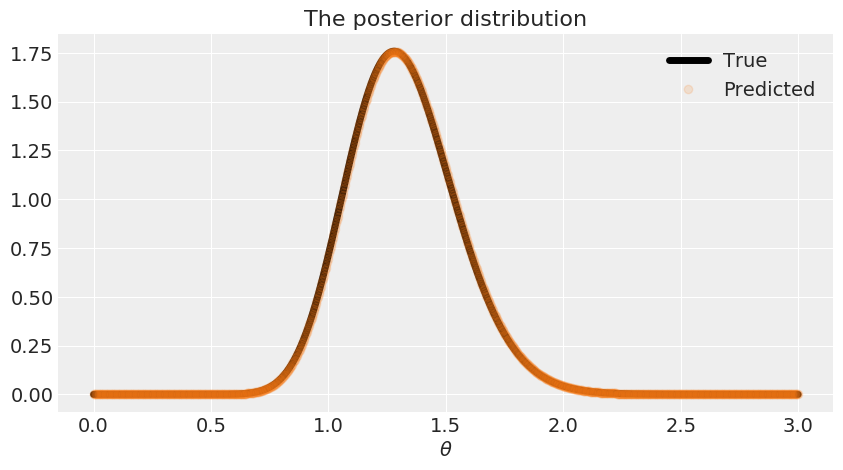

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'k', label='True', linewidth=5)
plt.plot(x, y_pred, 'oC1', label='Predicted', alpha=0.15)
plt.legend()
plt.title('The posterior distribution')
plt.xlabel(r'$\theta$', fontsize=14);

In [44]:
val = np.mean(trace_poisson_2['theta'] >= 1)
print(f'The posterior probability that theta exceeds 1.0 is {val:.2f}.')

The posterior probability that theta exceeds 1.0 is 0.93.


In [45]:
%watermark -iv -v -p theano,scipy,matplotlib,arviz -m

numpy 1.18.1
pymc3 3.8
arviz 0.7.0
CPython 3.6.8
IPython 7.12.0

theano 1.0.4
scipy 1.4.1
matplotlib 3.1.3
arviz 0.7.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 10.0.1 (clang-1001.0.46.4)
system     : Darwin
release    : 19.4.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
